# Classification - Binary
---

In [6]:
# Check GPU information
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
import torch
from scripts.utils import plot_predictions, plot_train_test_loss
from torch import nn
from pathlib import Path
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RANDOM_SEED = 42

## 1. Get data ready (turn into tensor)

In [8]:
n_samples = 1000
X, y = make_moons(n_samples, noise=0.03, random_state=RANDOM_SEED)

print(len(X), len(y))

1000 1000


In [9]:
df = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "y": y
})
df.head()

,X1,X2,y
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0


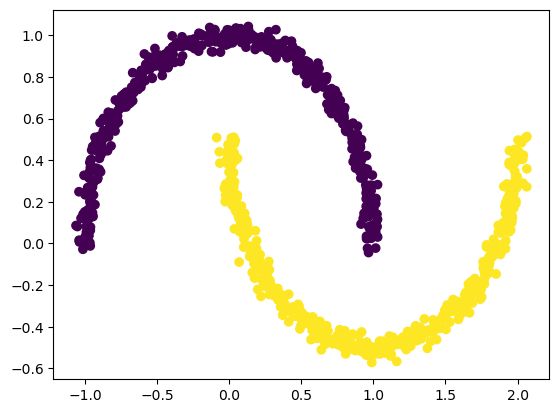

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [11]:
# Train test split

X_tensor = torch.tensor(X, device=DEVICE, dtype=torch.float32)
y_tensor = torch.tensor(y, device=DEVICE, dtype=torch.float32).unsqueeze(dim=1)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=RANDOM_SEED)
print(len(X_train), len(X_test), len(y_train), len(y_test))

800 200 800 200


## 2. Build or pick a pretrained model for training

In [12]:
class MoonModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features=2, out_features=50),
        nn.ReLU(),
        nn.Linear(in_features=50, out_features=80),
        nn.ReLU(),
        nn.Linear(in_features=80, out_features=1),
        nn.Sigmoid()
    )
  
  def forward(self, X):
    return self.model(X)


model = MoonModel()
model.to(device=DEVICE)

MoonModel(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=80, bias=True)
    (3): ReLU()
    (4): Linear(in_features=80, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

### 2.1 Pick loss function and optimizer

In [13]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

### 2.2 Build a training loop to train the model

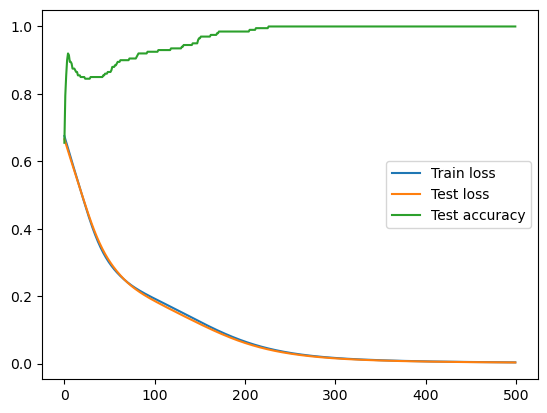

In [14]:
torch.manual_seed(RANDOM_SEED)

EPOCHS = 500
epoch_count = []
train_loss = []
test_loss = []
test_acc = []

for epoch in range(EPOCHS):
  epoch_count.append(epoch)

  # train
  model.train()
  y_pred = model(X_train)
  loss = loss_fn(y_pred, y_train)
  train_loss.append(loss)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # evaluate
  model.eval()
  with torch.inference_mode():
    y_pred = model(X_test)
    loss = loss_fn(y_pred, y_test)
    test_loss.append(loss)
    test_acc.append(accuracy_score(y_test.cpu().numpy(), torch.round(y_pred).cpu().numpy()))

plot_train_test_loss(epoch_count, train_loss, test_loss, test_acc)

## 3. Make prediction

In [15]:
model.eval()
with torch.inference_mode():
  y_pred = model(X_test)
  loss = loss_fn(y_pred, y_test)
  accuracy = accuracy_score(y_test.cpu().numpy(), torch.round(y_pred).cpu().numpy())

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Loss: 0.0030788856092840433
Accuracy: 1.0


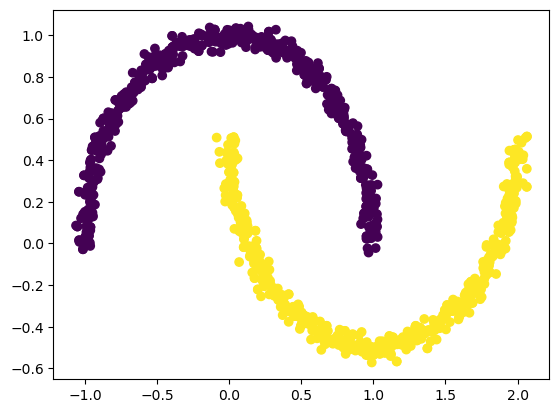

In [16]:
# Special plot function for classification
def plot_predictions(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=None
):
  X_train = X_train.cpu().numpy()
  X_test = X_test.cpu().numpy()
  y_train = y_train.cpu().numpy()
  y_test = y_test.cpu().numpy()
  if y_pred is not None:
    y_pred = y_pred.cpu().numpy()
  plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
  if y_pred is not None:
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

y_pred_rounded = torch.round(y_pred)
plot_predictions(y_pred=y_pred_rounded)

## 4. Evaluate the model

## 5. Improve through experimentation

## 6. Save and reload trained model

In [17]:
# Save the model

model_folder = Path("models")
model_folder.mkdir(parents=True, exist_ok=True)
model_name = "classification_binary_pytorch.pt"
model_path = model_folder / model_name

model.to(device=DEVICE)
torch.save(obj=model.state_dict(), f=model_path)

In [ ]:
# Load the model

loaded_model = MoonModel()
loaded_model.load_state_dict(torch.load(f=model_path))
loaded_model.to(device=DEVICE)
loaded_model.state_dict()

In [19]:
# Verify if the loading worked correctly

model.eval()
with torch.inference_mode():
  loaded_y_pred = loaded_model(X_test)
  loaded_loss = loss_fn(y_pred, y_test)

print(y_pred == loaded_y_pred)
print(loaded_loss == loss)

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        